**Importing Dependecies**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
import numpy as np
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
matplotlib.style.use('ggplot')
from torch.utils.data import DataLoader

**Helper Function**

In [2]:
#for plotting 
def set_default(figsize=(0, 10), dpi=100):    
    plt.rc('axes', facecolor='white')
    plt.rc('figure', facecolor='white')
    plt.rc('figure', figsize=figsize, dpi=dpi)

**Loading data**

In [3]:
data = scipy.io.loadmat('burgers_shock.mat')


Configuration

In [4]:
print(data['x'].shape)
print(data['t'].shape)
print(data['usol'].shape)

(256, 1)
(100, 1)
(256, 100)


In [5]:
x_dir = data['x']
time = data['t']
usolution = data['usol']


In [6]:
#Converting it to a tensor
usol_train=torch.from_numpy(usolution)
usol_train=np.reshape(usol_train,(1,25600))
usol_train=usol_train.float()
usol_train.shape



torch.Size([1, 25600])

**Plotting Original Solution**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'lw'
  This is separate from the ipykernel package so we can avoid doing imports until


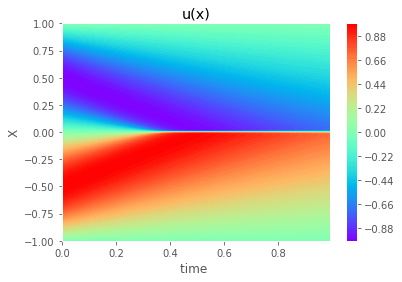

In [7]:
Time,X_coordinate = np.meshgrid(time,x_dir)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(Time, X_coordinate,np.reshape((usol_train),(256,100)),100,cmap='rainbow',lw=0)
ax.set_title('u(x)')
ax.set_xlabel('time ')
ax.set_ylabel('X')
plt.colorbar(cp)
plt.show()

**Data Loaders**

In [8]:
train_loader = DataLoader(dataset=usol_train,  shuffle=True)
train_loader


**Setting up a Model**

In [9]:
features =1
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__() 
        # encoder
        self.enc1 = nn.Linear(in_features=25600, out_features=500)
        self.enc2 = nn.Linear(in_features=500, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=500)
        self.dec2 = nn.Linear(in_features=500, out_features=25600)


    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

 
    def forward(self, x):

        # encoding
        x = F.relu(self.enc1(x))        
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding               
        x = self.dec1(z)               
        reconstruction = self.dec2(x)
        return reconstruction, mu, log_var


    def decode(self, z):
        x=self.dec1(z)
        return self.dec2(x)

    def sample_for_datagen(self, n_samples):
        z = torch.randn((n_samples, features))
        return self.decode(z)

In [10]:
# leanring parameters
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Initializing the Model, the Optimizer and the Loss Function**

In [11]:
model = LinearVAE()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

**Defining the final loss function**

In [12]:
def final_loss(mse_loss, mu, logvar):
    """
    This function will add the reconstruction loss (MSELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param mse_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = mse_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

**Training function**

In [13]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i,data in tqdm(enumerate(dataloader), total=int(len(usol_train)/dataloader.batch_size)):
        data = data
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        mse_loss = criterion(reconstruction, data)
        loss = final_loss(mse_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

**Training the model**

In [16]:
%%time
train_loss = []

epochs=200
for epoch in range(epochs):
    #print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    
    train_loss.append(train_epoch_loss)
    
    #print(f"Train Loss: {train_epoch_loss:.4f}")
    
    
print("\n\ntrain loss: " + str(train_epoch_loss))


**Training loss vs number of epochs**

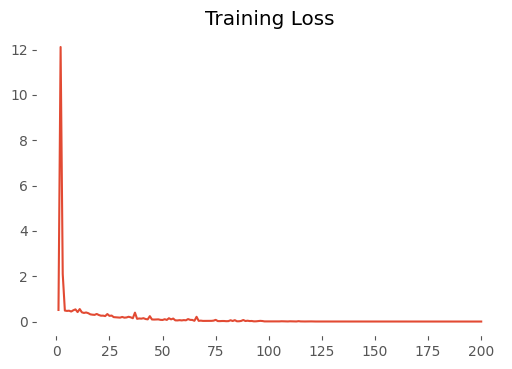

In [15]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss)

**Generating samples from latent space vector**

In [17]:
samples = model.sample_for_datagen(20)
samples=samples.detach().numpy()
samples.shape


(20, 25600)

**Plotting generated samples**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  import sys


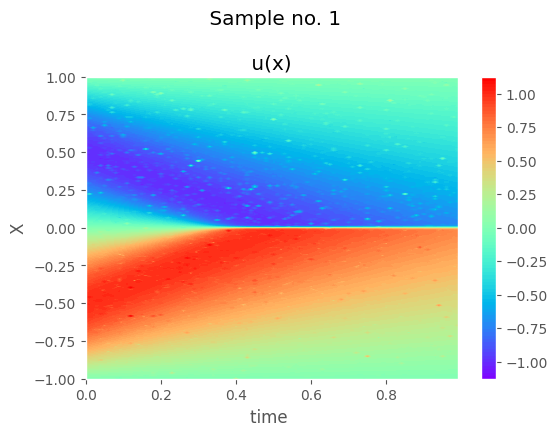

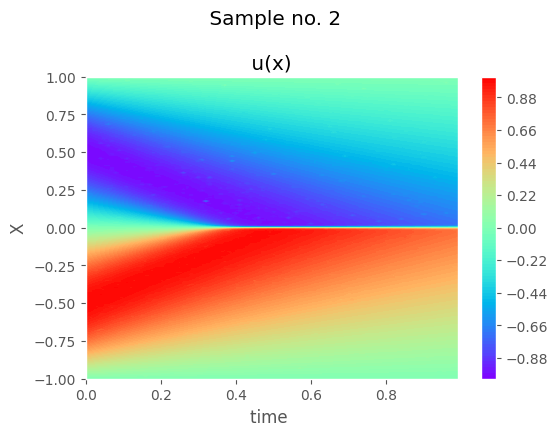

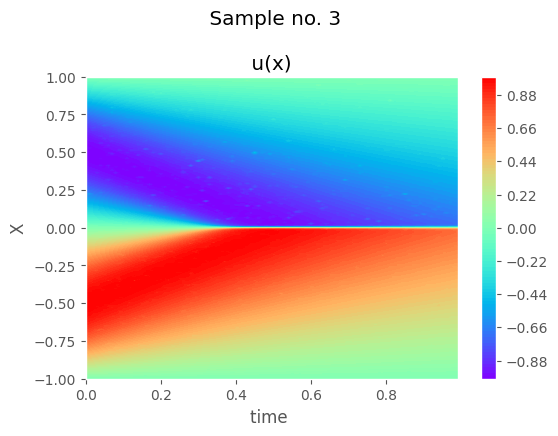

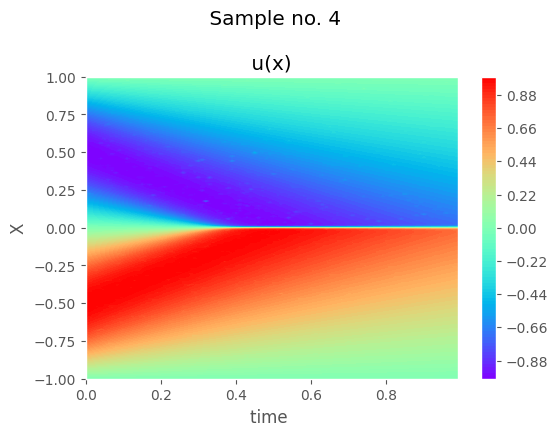

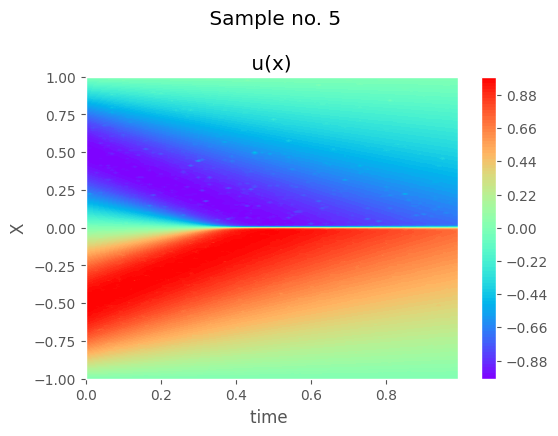

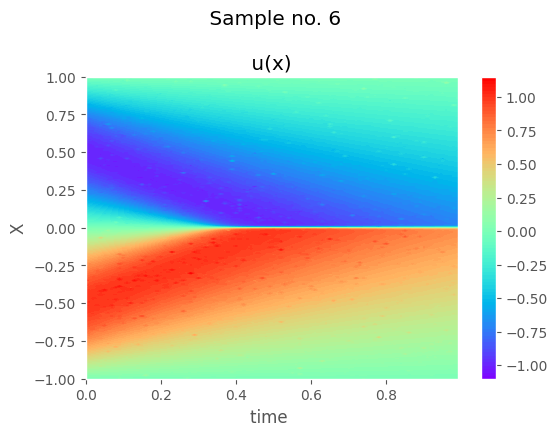

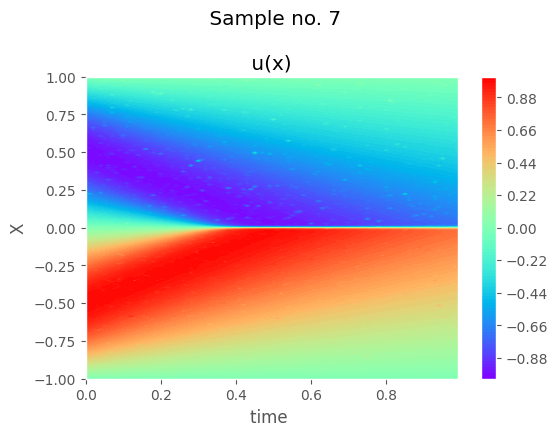

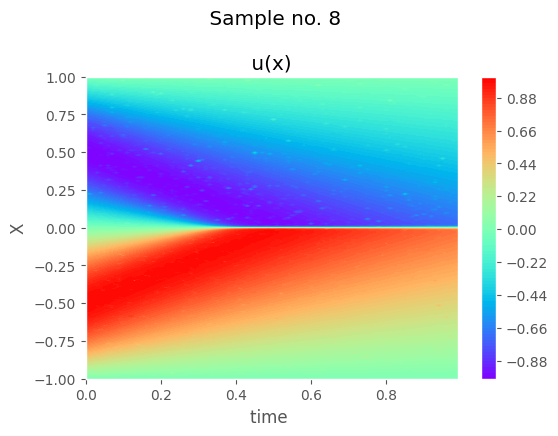

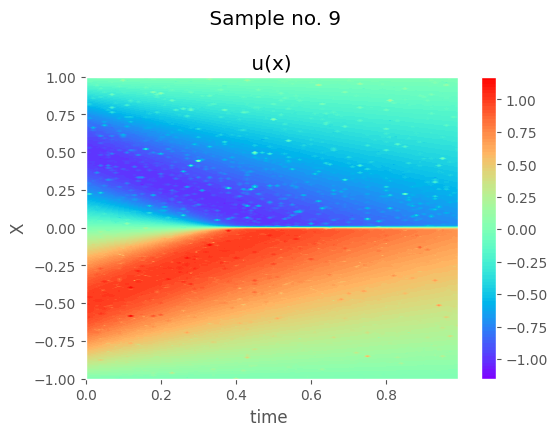

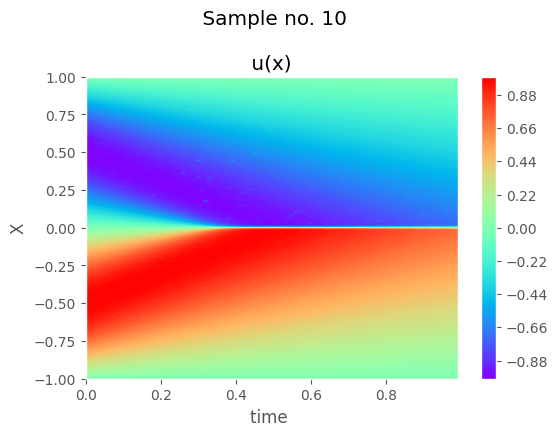

In [18]:

i=0

while i<10:
  fig,ax=plt.subplots(1,1)  
  plt.grid(color='w', linestyle='solid')
  cp = ax.contourf( Time,X_coordinate,np.reshape(samples[i],(256,100)),100,cmap='rainbow',lw=0)
  ax.set_title( ' Sample no. '+str(i+1)+ '\n\n u(x) ')
  
  ax.set_xlabel('time ')
  ax.set_ylabel('X')
  plt.colorbar(cp)
  plt.show()
  i=i+1



 **THE END**